# Synthetic Data Generation: Libraries Comparison (SDV and Synthicity)

## Introduction
In this notebook, we will compare two of the most prominent open-source Python packages for synthetic data generation: SDV and Synthcity. The focus is on generating single-table synthetic data, meaning the output will be a single structured dataset.

### Datset Description
The dataset used in this experiment comes from publicly available data on GitHub. It was collected by continuously monitoring a low-energy house in Belgium for 137 days, capturing both electrical energy consumption and environmental data. Energy consumption data was recorded every 10 minutes for various household appliances, while environmental data, such as temperature and humidity, was collected from multiple rooms through a wireless sensor network. Additionally, meteorological data from a nearby airport was merged into the dataset based on timestamps. The full dataset contains 19,735 records and 27 features, but I will only use a subset of it for two main reasons. First, the dataset is too large to be processed efficiently with limited computational resources. Second, I want to evaluate how well the synthetic data generators can generate more data than what they are initially provided with, testing their ability to expand and generalize in different scenarios.

### Analysis Overview
The analysis is structured in two main parts. First, I will explore the SDV and Synthcity packages by using their built-in functions to generate and analyze synthetic data. Then, I will move to the evaluation phase, which is further divided into two parts. The first part will focus on statistical similarities between real and synthetic data, using both the evaluation functions provided by the packages and a custom statistical function that compares key statistical properties such as mean, median, standard deviation, variance, as well as Kolmogorov-Smirnov distance and Wasserstein distance. The second part will evaluate the difference in machine learning model performance when trained on real vs. synthetic data.

It is important to note that in this second part, I am not trying to optimize the models in any way. The goal is not to find the best-performing dataset for machine learning but rather to measure how closely the synthetic data preserves the predictive properties of the real data. A good synthetic data generator should produce datasets that lead to similar machine learning performance as the real data, not necessarily better.

### Goals
The primary goal of this study is to evaluate which synthetic data generator performs best in creating data that is statistically similar to the real dataset.
The study also aims to explore how synthetic and real data differ when used to train machine learning models. By applying multiple machine learning models to both real and synthetic datasets, I will compare their predictive performance using key evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score. 
However, the goal is not to optimize these models but to assess how well the synthetic data preserves the predictive characteristics of the real dataset

Let's start!

First of all, let's import all the needed libraries.

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
from synthcity.plugins import Plugins

Next, we import the dataset containing household energy consumption data.

In [3]:
# Importing the training dataset that we will use to create syntethic data
df = pd.read_csv("Datasets/energydata_complete.csv", nrows=1000) # Taking only the first 1000 rows for memory limitation

# Inspect data 
print(df.head())

              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    9

Inspecting the dataset and handling missing values to ensure data quality before proceeding with analysis.

In [4]:
# Missing values
miss_info = df.isnull().sum()

treshold = 0.5 * len(df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
df = df.dropna(axis=1, thresh=treshold)
print(df.head())
print(df.isnull().sum().sum())

There are 0 columns with more than 500 missing values
              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed

Let's visualize the distribution of energy consumption present in the dataset (Recorded every 10 minutes)

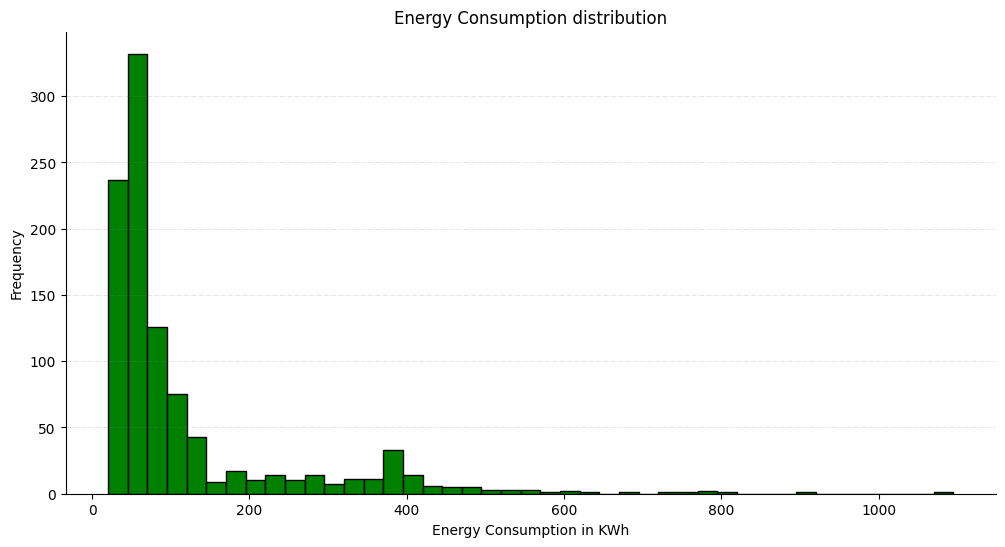

In [5]:
# define bins
min_a = min(df["Appliances"])
max_a = max(df["Appliances"])
binwidth = 25
bins = list(range(min_a, max_a + binwidth, binwidth))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.hist(df["Appliances"], bins=bins,color="green", edgecolor="black")
ax.set_xlabel("Energy Consumption in KWh")
ax.set_ylabel("Frequency")
ax.set_title("Energy Consumption distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False) 
plt.show()

## SDV
Now, let's begin our analysis with the first package: SDV. To correctly use SDV, we first need to define the metadata for our dataset. This metadata will provide the necessary structural information and will be essential for generating synthetic data.

In [6]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name="Energy_consumption")

print(metadata)

{
    "tables": {
        "Energy_consumption": {
            "columns": {
                "date": {
                    "sdtype": "datetime",
                    "datetime_format": "%m/%d/%Y %H:%M"
                },
                "Appliances": {
                    "sdtype": "numerical"
                },
                "lights": {
                    "sdtype": "categorical"
                },
                "T1": {
                    "sdtype": "numerical"
                },
                "RH_1": {
                    "sdtype": "numerical"
                },
                "T2": {
                    "sdtype": "numerical"
                },
                "RH_2": {
                    "sdtype": "numerical"
                },
                "T3": {
                    "sdtype": "numerical"
                },
                "RH_3": {
                    "sdtype": "numerical"
                },
                "T4": {
                    "sdtype": "numerical"
                

After defining the metadata, we can now create the synthesizer. Below is a description of a synthesizer as provided in the SDV documentation:

"The SDV creates synthetic data using machine learning. A synthesizer is an object that facilitates this process.

1. First, a synthesizer is created based on the dataset's metadata.
2. Next, it is trained using real data, where it learns patterns and relationships from the original dataset.
3. Once trained, the synthesizer can generate new synthetic data that mimics the real dataset."

SDV offers different types of synthesizers, each using a distinct machine learning technique. In this study, we will evaluate three synthesizers (for SDV):

- GaussianCopulaSynthesizer: Uses classic statistical methods to model and generate synthetic data.
- CTGANSynthesizer: Uses Generative Adversarial Networks (GANs) to capture complex data distributions and generate synthetic data.
- TVAESynthesizer: Uses Variational Autoencoders (VAEs), a type of deep learning model, to learn and replicate data distributions.

Each of these synthesizers follows a different approach to generating synthetic data, allowing us to compare the effectiveness of traditional statistical methods versus deep learning techniques.

Let's begin with the GaussianCopulaSynthesizer, which uses statistical methods to generate synthetic data.

In [7]:
# Create the synthesizer
synthesizer_gaussian_SDV = GaussianCopulaSynthesizer(metadata)

# Training
synthesizer_gaussian_SDV.fit(df)

# Syntetic data generation
synthetic_data_gaussian_SDV = synthesizer_gaussian_SDV.sample(num_rows=10000)
print(synthetic_data_gaussian_SDV)

# Save the data
synthetic_data_gaussian_SDV.to_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv", index=False)

KeyboardInterrupt: Error: Sampling terminated. No results were saved due to unspecified "output_file_path".


Next, let's try the CTGANSynthesizer. Since this model benefits from GPU acceleration, this step will be executed in a separate Google Colab notebook to take advantage of the free GPU resources available. The code for this process is still provided below, and the synthetic data generated by the CTGANSynthesizer will be imported later in this notebook for further analysis.

In [ ]:
# Create the synthesizer
synthesizer_CTGAN = CTGANSynthesizer(metadata)
# Training
synthesizer_CTGAN.fit(df)

# Syntetic data generation
synthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=10000)
print(synthetic_data_CTGAN)

# Save the data
synthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv", index=False)

KeyboardInterrupt: 

The same process is applied to the TVAESynthesizer, with training performed in a separate Google Colab notebook for GPU acceleration. The generated synthetic data will be imported later for evaluation.

In [ ]:
# Create the synthesizer
synthesizer_TVAE_SDV = TVAESynthesizer(metadata)

# Training
synthesizer_TVAE_SDV.fit(df)

# Syntetic data generation
synthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=10000)

# Save the data
synthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv", index=False)

Before manually comparing the statistical similarity between the synthetic and real data, I will first utilize some of the built-in diagnostic and data validation functions provided by the SDV package. To begin, I will use the run_diagnostic function, which performs a basic validity check on each column and ensures that the overall structure of the dataset is preserved. According to the package documentation, this function should return a score of 100% if the dataset is correctly structured.

In [ ]:
# Import the data created by the Three models (To not retrain the model everytime, and make the notebook run smothly)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")

print("Diagnostic Report for GaussianCopulaSynthesizer")
diagnostic_report_gaussian_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Diagnostic Report for CTGANSynthesizer")
diagnostic_report_CTGAN_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Diagnostic Report for TVAESynthesizer")
diagnostic_report_TVAE_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

Diagnostic Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1170.77it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 65.20it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1699.24it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 289.60it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1668.26it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 396.21it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



SDV also provides a function to generate a data quality report, which evaluates the statistical similarity between the real and synthetic data.

In [ ]:
# Create the quality report for the three models
# Commented out to smoothing the notebook running
print("Quality Report for GaussianCopulaSynthesizer")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

# Save these results
quality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")
quality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")
quality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")

Quality Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 90.58it/s]|
Column Shapes Score: 89.18%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:02<00:00, 198.71it/s]|
Column Pair Trends Score: 96.51%

Overall Score (Average): 92.85%

Quality Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 33.46it/s]|
Column Shapes Score: 75.69%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:03<00:00, 104.08it/s]|
Column Pair Trends Score: 84.96%

Overall Score (Average): 80.32%

Quality Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 63.95it/s]|
Column Shapes Score: 88.66%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 213.34it/s]|
Column Pair Trends Score: 94.94%

Overall Score (Average): 91.8%



Another feature offered by SDV is the ability to visualize the data in 2D. This helps in identifying the patterns learned by the synthetic data and spotting differences between the real and synthetic distributions.

In [ ]:
# Plot for the GaussianCopulaSynthesizer
fig_gaussian_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_gaussian_SDV.show()

In [ ]:
# Plot for the CTGAN model
fig_CTGAN_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_CTGAN_SDV.show()

In [ ]:
# Plot for the TVAESynthesizer model
fig_TVAE_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_TVAE_SDV.show()

## Synthcity 
Now, let's begin analyzing Synthcity. Unlike SDV, it does not offer as many built-in functionalities, so I will focus on using the models it provides. In particular, I will evaluate the following synthesizers:

- Bayesian Network Synthesizer – Similar to Gaussian Copula, it relies on statistical methods rather than deep learning.
- CTGAN – The same GAN-based model as the one used in SDV.
- TVAE – The same VAE-based model as the one used in SDV.

Just like with the SDV models, I will train these Synthcity models in a separate notebook. However, the code is still provided below.

In [ ]:
# Check available models
print(Plugins().list())

# Create Bayesian Network Model (Comparison with SDV GaussianCopula)
synthesizer_bayes_net_SYN = Plugins().get("bayesian_network")
print("Model initialized Successfully")

# Train on real data (TRAIN ON GPU)
synthesizer_bayes_net_SYN.fit(df)

# Generate synthetic data
synthetic_data_bayes_net_SYN = synthesizer_bayes_net_SYN.generate(10000).dataframe()

# Save the data
synthetic_data_bayes_net_SYN.to_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv", index=False)

# Model to compare
# GaussianCopula VS bayesian_network (Both probabilistic models)
# CTGAN VS ctgan (Exact match)
# TVAE VS tvae (Exact Match)

[2025-03-09T02:04:30.555077+0100][25180][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-03-09T02:04:35.044741+0100][25180][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


['timegan', 'survival_gan', 'timevae', 'arf', 'great', 'adsgan', 'pategan', 'image_cgan', 'bayesian_network', 'uniform_sampler', 'marginal_distributions', 'nflow', 'decaf', 'ctgan', 'survae', 'dpgan', 'dummy_sampler', 'privbayes', 'image_adsgan', 'rtvae', 'aim', 'fflows', 'survival_ctgan', 'radialgan', 'ddpm', 'tvae', 'survival_nflow']
Model initialized Successfully


03/09/2025 02:04:41:WARNING:Probability values don't exactly sum to 1. Differ by: -4.440892098500626e-16. Adjusting values.


In [ ]:
# Create Conditional GAN (Comparison with SDV CTGAN)
synthesizer_ctgan_SYN = Plugins().get("ctgan")

# Train the model
synthesizer_ctgan_SYN.fit(df)

# Create and save the data
synthetic_data_ctgan_SYN = synthesizer_ctgan_SYN.generate(10000).dataframe()
synthetic_data_ctgan_SYN.to_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv", index=False)

[2025-03-09T02:04:45.581153+0100][25180][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
  0%|          | 0/2000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Create Triplet-Based Variational Autoencoder (Comparison with SDV TVAE)
synthesizer_tvae_SYN = Plugins().get("tvae")

# Train the model
synthesizer_tvae_SYN.fit(df)

# Create synthetic and save them
synthetic_data_tvae_SYN = synthesizer_tvae_SYN.generate(10000).dataframe()
synthetic_data_tvae_SYN.to_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv", index=False)

## Statistical Analysis of Real vs. Synthetic Datasets

First, for a quick comparison, let's use the built-in functions provided by SDV.

In [8]:
# Import all the necessary datasets
real_df = pd.read_csv("Datasets/energydata_complete.csv", nrows=10000)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")
synthetic_data_bayes_net_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv")
synthetic_data_ctgan_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv")
synthetic_data_tvae_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv")

# Evaluate quality with SDV built in package
print("Quality Report for GaussianCopulaSynthesizer SDV")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer SDV")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer SDV")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)


Quality Report for GaussianCopulaSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 259.99it/s]|
Column Shapes Score: 74.61%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 259.75it/s]|
Column Pair Trends Score: 87.9%

Overall Score (Average): 81.26%

Quality Report for CTGANSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 250.85it/s]|
Column Shapes Score: 70.79%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 262.69it/s]|
Column Pair Trends Score: 84.61%

Overall Score (Average): 77.7%

Quality Report for TVAESynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 262.56it/s]|
Column Shapes Score: 70.95%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 255.65it/s]|
Column Pair Trends Score: 86.35%

Overall Score (Average): 78.65%



In [ ]:
print("Quality Report for Bayesian Network SYN")
quality_report_bayes_net_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_bayes_net_SYN,
    metadata=metadata
)

print("Quality Report for ctgan SYN")
quality_report_ctgan_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_ctgan_SYN,
    metadata=metadata
)

print("Quality Report for tvae SYN")
quality_report_tvae_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_tvae_SYN,
    metadata=metadata
)

Quality Report for Bayesian Network SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 253.64it/s]|
Column Shapes Score: 77.79%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 287.65it/s]|
Column Pair Trends Score: 88.46%

Overall Score (Average): 83.13%

Quality Report for ctgan SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 282.61it/s]|
Column Shapes Score: 71.32%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 272.35it/s]|
Column Pair Trends Score: 86.36%

Overall Score (Average): 78.84%

Quality Report for tvae SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 279.94it/s]|
Column Shapes Score: 69.42%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 257.08it/s]|
Column Pair Trends Score: 86.65%

Overall Score (Average): 78.04%



Let's now visualize the distribution differences for the "Appliances" column in each real and synthetic dataset, too see how well the synthetic data resemble the real data distribution.

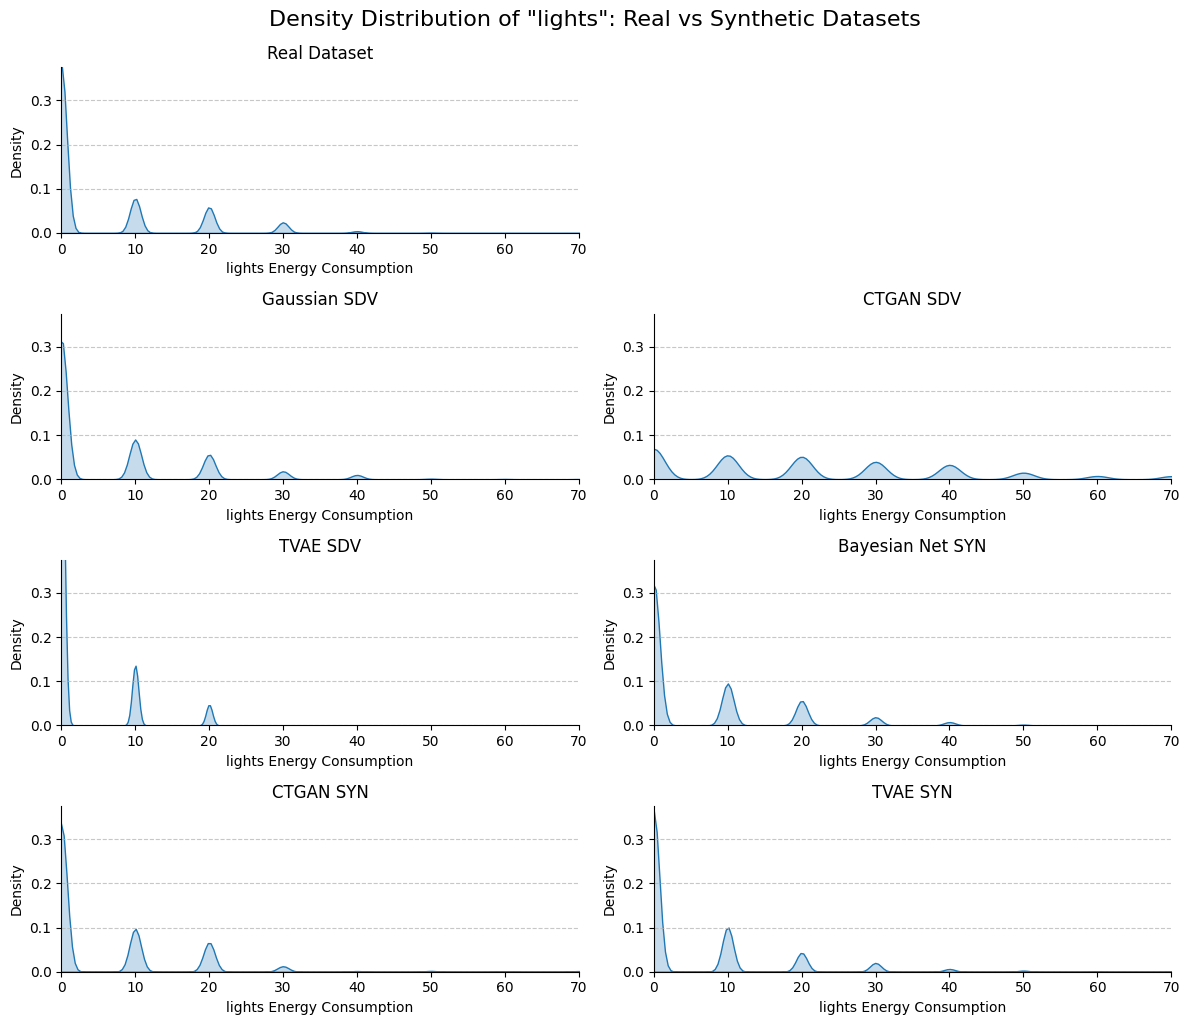

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(12, 10))

column_to_visualize = "lights"

# Define common x-axis range from real data
xmin = real_df[column_to_visualize].min()
xmax = real_df[column_to_visualize].max()

# Create the density plots
sns.kdeplot(real_df[column_to_visualize], fill=True, ax=ax[0, 0], bw_adjust=0.5)
ax[0, 0].set_title("Real Dataset")
fig.delaxes(ax[0, 1])

sns.kdeplot(synthetic_data_gaussian_SDV[column_to_visualize], fill=True, ax=ax[1, 0], bw_adjust=0.5)
ax[1, 0].set_title("Gaussian SDV")

sns.kdeplot(synthetic_data_CTGAN_SDV[column_to_visualize], fill=True, ax=ax[1, 1], bw_adjust=0.5)
ax[1, 1].set_title("CTGAN SDV")

sns.kdeplot(synthetic_data_TVAE_SDV[column_to_visualize], fill=True, ax=ax[2, 0], bw_adjust=0.5)
ax[2, 0].set_title("TVAE SDV")

sns.kdeplot(synthetic_data_bayes_net_SYN[column_to_visualize], fill=True, ax=ax[2, 1], bw_adjust=0.5)
ax[2, 1].set_title("Bayesian Net SYN")

sns.kdeplot(synthetic_data_ctgan_SYN[column_to_visualize], fill=True, ax=ax[3, 0], bw_adjust=0.5)
ax[3, 0].set_title("CTGAN SYN")

sns.kdeplot(synthetic_data_tvae_SYN[column_to_visualize], fill=True, ax=ax[3, 1], bw_adjust=0.5)
ax[3, 1].set_title("TVAE SYN")

for axes in ax.flat:
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.grid(axis="y", linestyle="--", alpha=0.7)
    axes.set_xlabel(f"{column_to_visualize} Energy Consumption")
    axes.set_ylabel("Density")
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(0, 0.25 * 1.5)  # * 1.35 to show even the highest peak

fig.tight_layout()
fig.suptitle(f"Density Distribution of \"{column_to_visualize}\": Real vs Synthetic Datasets", fontsize=16, y=1.02)
plt.show()


To systematically compare the statistical similarity between real and synthetic datasets, I implemented a custom function called overall_similarity. This function evaluates how closely the synthetic data resembles the real data by computing normalized differences in key statistical properties.

The function considers classic statistical measures (mean, median, mode, standard deviation, variance) along with distributional similarity metrics, Kolmogorov-Smirnov (KS) test and Wasserstein distance. These two distribution-based metrics were specifically chosen because they are used internally by SDV’s built-in evaluation functions, as seen in the SDV source code.

The similarity score is computed by applying weighted penalties for statistical deviations, meaning that lower discrepancies between real and synthetic data lead to a higher score. The final output is a percentage-based score (0 to 100), where 100 indicates perfect similarity.

In [54]:
# Create the function
def overall_similarity(real_df, synthetic_df, 
                       weight_mean=0.3, weight_median=0.2, weight_mode=0.1, weight_sd=0.1, weight_var=0.1,
                       weight_ks=0.2, weight_wasserstein=0.1):
    """
    Computes an overall similarity score between real and synthetic datasets based
    on normalized differences in mean, median (if numerical) and mode (if categorical) across columns.

    Parameters:
    - real_df (pd.DataFrame): Real dataset
    - synthetic_df (pd.DataFrame): Synthetic dataset
    - weight_mean (float, optional): Weight for mean difference. Defaults to 0.3.
    - weight_median (float, optional): Weight for median difference. Defaults to 0.3.
    - weight_mode (float, optional): Weight for mode difference. Defaults to 0.2.
    - weight_sd (float, optional): Weight for standard deviation difference. Defaults to 0.1
    - weight_var (float, optional): Weight for variance difference. Defaults to 0.1

    Returns:
    Returns a score between 0 and 100, where 100 indicates perfect similarity.
    """

    # Drop datetime columns
    real_df = real_df.select_dtypes(exclude=["datetime64"])
    synthetic_df = synthetic_df.select_dtypes(exclude=["datetime64"])

    scores = []
    common_cols = set(real_df.columns).intersection(set(synthetic_df.columns))

    for col in common_cols:
        # Check if numerical
        if pd.api.types.is_numeric_dtype(real_df[col]):
            # Classic statistics
            real_mean, syn_mean = real_df[col].mean(), synthetic_df[col].mean() 
            real_median, syn_median = real_df[col].median(), synthetic_df[col].median()
            real_sd, syn_sd = real_df[col].std(), synthetic_df[col].std()
            real_var, syn_var = real_df[col].var(), synthetic_df[col].var()
            
            # Avoid division by zero
            norm_mean = min(1, abs(real_mean - syn_mean) / (abs(real_mean) + 1e-6))
            norm_median = min(1, abs(real_median - syn_median) / (abs(real_median) + 1e-6))
            norm_sd = min(1, abs(real_sd - syn_sd) / (abs(real_sd) + 1e-6))
            norm_var = min(1, abs(real_var - syn_var) / (abs(real_var) + 1e-6))
      
            # Kolomogorov-Smirnov Test (Checks if distributions are similar)
            ks_stat, _ = ks_2samp(real_df[col].dropna(), synthetic_df[col].dropna())
        
            # Wasserstein Distance (Lower means closer distributions)
            wasserstein_dist = wasserstein_distance(real_df[col].dropna(), synthetic_df[col])
            norm_wasserstein = 1 / (1 + wasserstein_dist) # now between 0 and 1

            col_score = 1 - (weight_mean * norm_mean + 
                             weight_median * norm_median + 
                             weight_sd * norm_sd + 
                             weight_var * norm_var +
                             weight_ks * ks_stat + 
                             weight_wasserstein * (1 - norm_wasserstein))
        
        else:
            real_mode = real_df[col].mode()
            syn_mode = synthetic_df[col].mode()
            if not real_mode.empty and not syn_mode.empty:
                mode_score = 1.0 if real_mode.iloc[0] == syn_mode.iloc[0] else 0.0
            else:
                mode_score = 0.0
            col_score = mode_score* weight_mode
        
        scores.append(col_score)
    
    overall_score = np.mean(scores) * 100
    return round(overall_score, 2)


Test the function on different subset of the same (real) dataset, the score should be close to 100.

In [55]:
# Split the real dataset in two random subsets
real_data_part_1, real_data_part_2 = train_test_split(real_df, test_size=0.5, random_state=1618)

# Evaluate the two parts on the statistical function
sim_score_test = overall_similarity(real_data_part_1, real_data_part_2)
print(f"Similarity score: {sim_score_test}")

Similarity score: 97.99


Evaluate the datasets based on this function

In [ ]:
sim_score_gaussian_SDV = overall_similarity(real_df, synthetic_data_gaussian_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Gaussian SDV: ", sim_score_gaussian_SDV)

sim_score_CTGAN_SDV = overall_similarity(real_df, synthetic_data_CTGAN_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SDV: ", sim_score_CTGAN_SDV)

sim_score_TVAE_SDV = overall_similarity(real_df, synthetic_data_TVAE_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SDV: ", sim_score_TVAE_SDV)

sim_score_bayes_net_SYN = overall_similarity(real_df, synthetic_data_bayes_net_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Bayes Net SYN: ", sim_score_bayes_net_SYN)

sim_score_ctgan_SYN = overall_similarity(real_df, synthetic_data_ctgan_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SYN: ", sim_score_ctgan_SYN)

sim_score_tvae_SYN =  overall_similarity(real_df, synthetic_data_tvae_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SYN: ", sim_score_tvae_SYN)

Similarity between real data and synthetic data with Gaussian SDV:  79.83
Similarity between real data and synthetic data with CTGAN SDV:  77.47
Similarity between real data and synthetic data with TVAE SDV:  75.91
Similarity between real data and synthetic data with Bayes Net SYN:  80.69
Similarity between real data and synthetic data with CTGAN SYN:  79.19
Similarity between real data and synthetic data with TVAE SYN:  78.59


## Evaluating Predictive Utility

This step aims to compare how well machine learning models trained on real data perform against those trained on synthetic data. The goal is not to optimize model performance but to assess how closely the synthetic data preserves the predictive characteristics of the real dataset. 

To assess how well synthetic data preserves the predictive properties of real data, the function in the following codeblock trains multiple machine learning models on both real and synthetic datasets and stores the results in a structured format.

Rather than directly comparing the performances, the function organizes the evaluation metrics (MAE, MSE, R²) into three key outputs:

- real_metrics_df – The performance of ML models trained on real data.
- detailed_syn_metrics – The performance of ML models trained on each synthetic dataset, stored in a nested dictionary for granular analysis.
- overall_syn_metrics_df – The average performance of each synthetic data generator across all ML models, making it easier to analyze general trends.

This structured output allows for further comparisons and analysis in subsequent steps, where we can examine the differences between real and synthetic data performances.

In [56]:
# Divide all the datasets in training and targets
X_real = real_df.drop(["Appliances", "date"], axis=1)
y_real = real_df["Appliances"]

X_gaussian_SDV = synthetic_data_gaussian_SDV.drop(["Appliances", "date"], axis=1)
y_gaussian_SDV = synthetic_data_gaussian_SDV["Appliances"]

X_bayes_net_SYN = synthetic_data_bayes_net_SYN.drop(["Appliances", "date"], axis=1)
y_bayes_net_SYN = synthetic_data_bayes_net_SYN["Appliances"]

X_CTGAN_SDV = synthetic_data_CTGAN_SDV.drop(["Appliances", "date"], axis=1)
y_CTGAN_SDV = synthetic_data_CTGAN_SDV["Appliances"]

X_ctgan_SYN = synthetic_data_ctgan_SYN.drop(["Appliances", "date"], axis=1)
y_ctgan_SYN = synthetic_data_ctgan_SYN["Appliances"]

X_TVAE_SDV = synthetic_data_TVAE_SDV.drop(["Appliances", "date"], axis=1)
y_TVAE_SDV = synthetic_data_TVAE_SDV["Appliances"]

X_tvae_SYN = synthetic_data_tvae_SYN.drop(["Appliances", "date"], axis=1)
y_tvae_SYN = synthetic_data_tvae_SYN["Appliances"]

synthetic_datasets = {
    "Gaussian SDV": (X_gaussian_SDV, y_gaussian_SDV),
    "Bayes Net SYN": (X_bayes_net_SYN, y_bayes_net_SYN),
    "CTGAN SDV": (X_CTGAN_SDV, y_CTGAN_SDV),
    "CTGAN SYN": (X_ctgan_SYN, y_ctgan_SYN),
    "TVAE SDV": (X_TVAE_SDV, y_TVAE_SDV),
    "TVAE SYN": (X_tvae_SYN, y_tvae_SYN)
}

models = {
    "XGB": XGBRegressor(colsample_bytree = 0.8, 
                     gamma = 0, learning_rate = 0.1, 
                     max_depth = 5, 
                     n_estimators = 100, 
                     subsample = 1.0, 
                     random_state=1618),
    "RF": RandomForestRegressor(max_depth=40, max_features="sqrt", n_estimators=240),
    "SVR": SVR(C=8, gamma=1, kernel="rbf"),
    "Linear": LinearRegression()
}

def evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618, repeats=10):
    """
    Evaluate all models on all synthetic datasets using repeated holdout for robust results.

    Parameters:
    - X_real (pd.DataFrame): Features from the real dataset
    - y_real (pd.Series): Target variable from the real dataset
    - synthetic_datasets (dict): Dictionary of synthetic datasets
    - models (dict): Dictionary of models to evaluate
    - test_size (float, optional): Proportion of data to use for testing. Defaults to 0.2.
    - random_state (int, optional): Seed for random number generation. Defaults to 1618
    - repeats (int, optional): Number of random splits of the data for statistical significant results. Defaults to 1

    Returns:
    - real_metrics_df (pd.DataFrame): Evaluation metrics for each model on real data
    - overall_syn_metrics_df (pd.DataFrame): Average Evaluation metrics
    - detailed_syn_metrics (dict): Nested dictionary of metrics for each synthetic data generator 
    """

    # Scale the data
    scaler = StandardScaler()
    X_real_scaled = scaler.fit_transform(X_real)

    # Dictionaries to hold repeated metrics
    real_metrics_accum = {model_name: [] for model_name in models}
    detailed_syn_metrics_accum = {method: {model_name: [] for model_name in models} for method in synthetic_datasets}

    # Repeated holdouts
    for i in range(repeats):
        current_seed = random_state + i # change random state everytime to evaluate different part of the dataframe

        # Split real data
        X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
            X_real_scaled, y_real, test_size=test_size, random_state=current_seed
        )

        # Evaluate all models on real data
        for model_name, model in models.items():
            model_clone = clone(model)
            model_clone.fit(X_train_real, y_train_real)
            y_pred_real = model_clone.predict(X_test_real)

            real_metrics_accum[model_name].append({
                "MAE": mean_absolute_error(y_test_real, y_pred_real),
                "MSE": mean_squared_error(y_test_real, y_pred_real),
                "R2": r2_score(y_test_real, y_pred_real)
            })
        
        # Evaluate synthetic data 
        for method, (X_syn, y_syn) in synthetic_datasets.items():
            X_syn_scaled = scaler.transform(X_syn)

            # Split the syn data (To ensure same proportions)
            X_train_syn, _ , y_train_syn, _ = train_test_split(
                X_syn_scaled, y_syn, test_size=test_size, random_state=current_seed
            )

            for model_name, model in models.items():
                model_clone = clone(model)
                model_clone.fit(X_train_syn, y_train_syn)
                y_pred_syn = model_clone.predict(X_test_real) # Test on REAL data
                
                # Test everything on REAL data
                detailed_syn_metrics_accum[method][model_name].append({
                    "MAE": mean_absolute_error(y_test_real, y_pred_syn),
                    "MSE": mean_squared_error(y_test_real, y_pred_syn),
                    "R2": r2_score(y_test_real, y_pred_syn)
                })
    
    # Avarege all the results
    real_metrics = {
        model_name: {
            metric: np.mean([res[metric] for res in results])
            for metric in ["MAE", "MSE", "R2"]
        }
        for model_name, results in real_metrics_accum.items()
    }

    real_metrics_df = pd.DataFrame(real_metrics).T

    # Same for synthetic data
    detailed_syn_metrics = {
        method: {
            model_name: {
                metric: np.mean([res[metric] for res in results])
                for metric in ["MAE", "MSE", "R2"]
            }
            for model_name, results in model_dict.items()
        }
        for method, model_dict in detailed_syn_metrics_accum.items()
    }

    # Compute overall avareges for synthetic data
    overall_syn_metrics = {
        method: {
            "MAE_avg": np.mean([metrics["MAE"] for metrics in model_dict.values()]),
            "MSE_avg": np.mean([metrics["MSE"] for metrics in model_dict.values()]),
            "R2_avg": np.mean([metrics["R2"] for metrics in model_dict.values()]),
        }
        for method, model_dict in detailed_syn_metrics.items()
    }

    overall_syn_metrics_df = pd.DataFrame(overall_syn_metrics).T # Transpose to have metrics as columns

    return real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics

Test the function on same dataset to ensure reliability (The performances should be very similar)

In [59]:
# Create fake dictionary
real_data_dict = {
    "Real_Data": (X_real, y_real)
}

# Evaluate function
real_metric_1, real_metric_2, _ = evaluate_all_models(X_real, y_real, real_data_dict, models, test_size=0.2, random_state=1618, repeats=5)
real_metric_2.to_csv("Metrics_performances/TEST_EQUAL_TO_REAL.csv", index=False)
print(real_metric_1.mean()[["MAE", "MSE", "R2"]])
print(real_metric_2.head())

MAE      45.941682
MSE    8298.822135
R2        0.294309
dtype: float64
            MAE_avg      MSE_avg    R2_avg
Real_Data  45.93896  8296.500177  0.294554


Now, let's use the function to generate the structured DataFrames needed for further analysis and comparison.

In [ ]:
# Create the metrics datasets
real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics = evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618, repeats=10)

real_metrics_df.to_csv("Metrics_performances/real_metrics.csv", index=False)
overall_syn_metrics_df.to_csv("Metrics_performances/overall_syn_metrics.csv", index=False)
print(real_metrics_df.head())
print(overall_syn_metrics_df.head())
print(detailed_syn_metrics)

KeyboardInterrupt: 

Compute the absolute and relative differences between the performances of ML models on real and synthetic data. The smaller the difference, the better the synthetic data replicates the characteristics of the real dataset. It is important to note that we are not trying to identify the model that achieves the best performance but rather the synthetic data generator that produces results most aligned with those obtained from real data.

In [61]:
# Import dataframes
real_metrics_df = pd.read_csv("Metrics_performances/real_metrics.csv")
overall_syn_metrics_df = pd.read_csv("Metrics_performances/overall_syn_metrics.csv")
TEST = pd.read_csv("Metrics_performances/TEST_EQUAL_TO_REAL.csv")

# Compute the differences
diff_metrics = overall_syn_metrics_df.copy()
diff_metrics_TEST = TEST.copy()
print(overall_syn_metrics_df.index)

# Absolute difference
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics[f"Delta_{metric}"] = abs(real_metrics_df.mean()[metric] - overall_syn_metrics_df[f"{metric}_avg"])

# TEST
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics_TEST[f"Delta_TEST_{metric}"] = abs(real_metrics_df.mean()[metric] - TEST[f"{metric}_avg"])

# Percentages, relative difference
for metric in ["MAE", "MSE"]:
    diff_metrics[f"Real_Delta_{metric} (%)"] = (diff_metrics[f"Delta_{metric}"] / (real_metrics_df.mean()[metric])) * 100

# For R2 the difference is simplier since it's already a percentage
diff_metrics["Real_Delta_R2 (%)"] = (diff_metrics["Delta_R2"] / (real_metrics_df.mean()["R2"])) * 100 # CHECK HERE

model_names = ["Gaussian SDV", "Bayesian Net SYN", "CTGAN SDV", "ctgan SYN", "TVAE SDV", "tvae SYN"]
diff_metrics.index = model_names
print(diff_metrics.index)

#print(diff_metrics)
print(diff_metrics_TEST)


RangeIndex(start=0, stop=6, step=1)
Index(['Gaussian SDV', 'Bayesian Net SYN', 'CTGAN SDV', 'ctgan SYN',
       'TVAE SDV', 'tvae SYN'],
      dtype='object')
    MAE_avg      MSE_avg    R2_avg  Delta_TEST_MAE  Delta_TEST_MSE  \
0  45.93896  8296.500177  0.294554        0.277068      122.417533   

   Delta_TEST_R2  
0       0.002047  


Visualize the results using a bar plot to compare the percentage differences between real and synthetic data across the three evaluation metrics (MAE, MSE, and R²). 

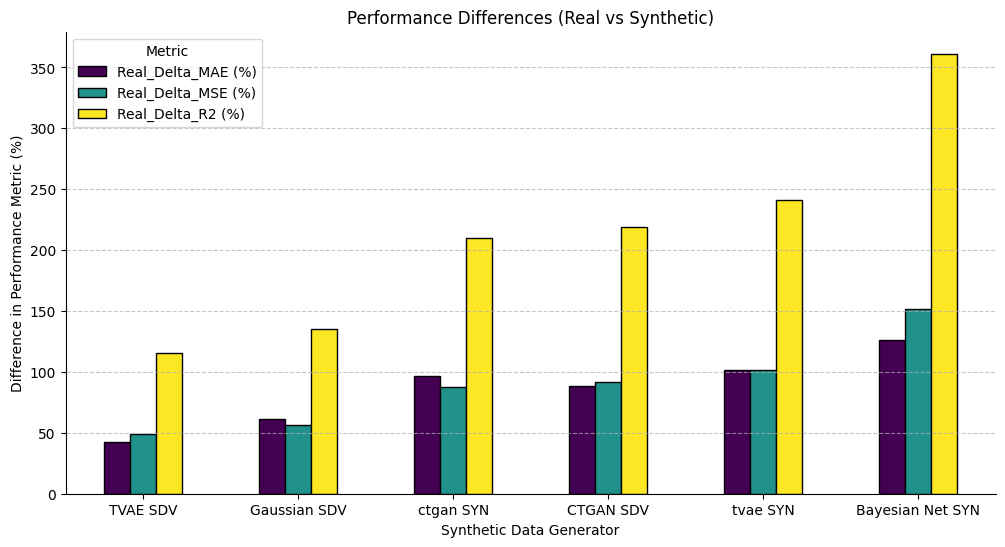

In [ ]:
metrics = ["Real_Delta_MAE (%)", "Real_Delta_MSE (%)", "Real_Delta_R2 (%)"]

fig, ax = plt.subplots(figsize=(12,6))
# Plot bar chart
diff_metrics[metrics].plot(kind="bar", ax=ax, colormap="viridis", edgecolor="black")

ax.set_title("Performance Differences (Real vs Synthetic)")
ax.set_ylabel("Difference in Performance Metric (%)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Metric")
plt.show()


To get a clearer picture of which synthetic data generator overall produces data that best aligns with the performance of real data across different ML models, we create a single aggregated metric that combines MAE, MSE, and R².

    MAE_avg      MSE_avg    R2_avg  Delta_TEST_MAE  Delta_TEST_MSE  \
0  45.93896  8296.500177  0.294554        0.277068      122.417533   

   Delta_TEST_R2  MAE_Score  MSE_Score  R2_Score  
0       0.002047   0.993932   0.985024  0.993099  
                  MAE_Score  MSE_Score  R2_Score
TVAE SDV           0.576579   0.513717 -0.158589
Gaussian SDV       0.383120   0.432315 -0.356632
ctgan SYN          0.033132   0.120198 -1.097737
CTGAN SDV          0.112465   0.085709 -1.193707
tvae SYN          -0.019993  -0.015710 -1.411919
Bayesian Net SYN  -0.260803  -0.514230 -2.612894
TVAE SDV            0.310569
Gaussian SDV        0.152935
ctgan SYN          -0.314802
CTGAN SDV          -0.331844
tvae SYN           -0.482541
Bayesian Net SYN   -1.129309
Name: Overall_Score, dtype: float64
0    0.990685
Name: Overall_Score, dtype: float64


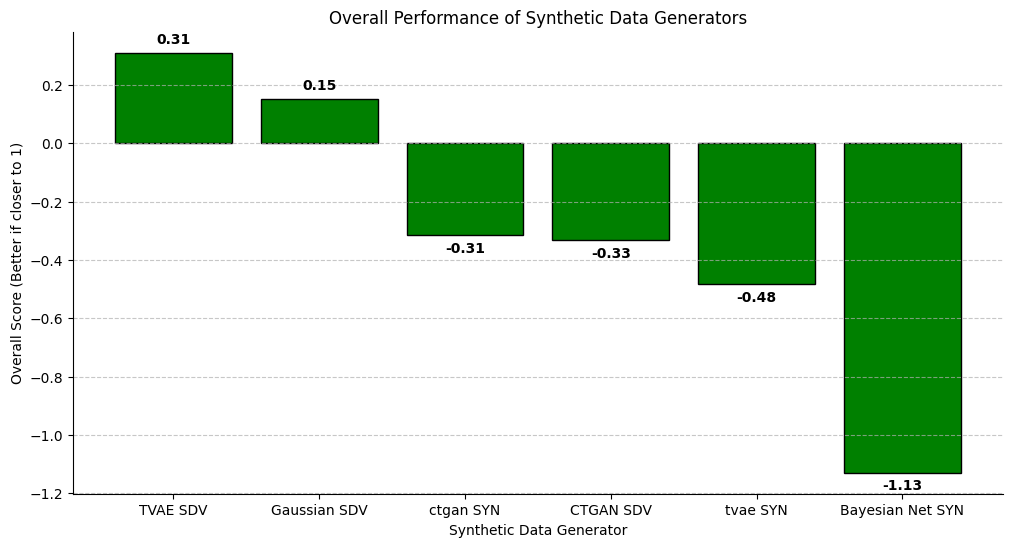

In [64]:
# Calculate the scores
diff_metrics["MAE_Score"] = 1 - (diff_metrics["Delta_MAE"] / real_metrics_df.mean()["MAE"]) 
diff_metrics["MSE_Score"] = 1 - (diff_metrics["Delta_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics["R2_Score"] = 1 - (diff_metrics["Delta_R2"] / real_metrics_df.mean()["R2"])

# TEST
diff_metrics_TEST["MAE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MAE"] / real_metrics_df.mean()["MAE"])
diff_metrics_TEST["MSE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics_TEST["R2_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_R2"] / real_metrics_df.mean()["R2"])
print(diff_metrics_TEST)

# Creating a overall score (since now MAE_Score, MSE_Score and R2_Score are in the same range (-inf, 1])
diff_metrics["Overall_Score"] = (diff_metrics[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics = diff_metrics.sort_values(by="Overall_Score", ascending=False)
print(diff_metrics[["MAE_Score", "MSE_Score", "R2_Score"]])
print(diff_metrics["Overall_Score"])

# TEST 
diff_metrics_TEST["Overall_Score"] = (diff_metrics_TEST[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics_TEST = diff_metrics_TEST.sort_values(by="Overall_Score")
print(diff_metrics_TEST["Overall_Score"])

# Visualize the rank
fig, ax = plt.subplots(1,1,figsize=(12,6))
bars = ax.bar(diff_metrics.index, diff_metrics["Overall_Score"], color="green", edgecolor="black")

for bar in bars:
    height = bar.get_height()
    if height >= 0:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height + 0.02,
                f"{height:.2f}",
                ha="center", va="bottom",
                fontsize=10, fontweight="bold")
    else:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height - 0.02,
                f"{height:.2f}",
                ha="center", va="top",
                fontsize=10, fontweight="bold")

ax.set_title("Overall Performance of Synthetic Data Generators")
ax.set_ylabel("Overall Score (Better if closer to 1)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# NO CONCLUSIONS YET
